In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2023-11-23 23:06:02.365649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [85]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Load the augmented data from the saved file
# data = np.load('/content/drive/My Drive/Capstone/Pickled/coral_augmented_combined_RCNN.npz')

# # Access the arrays from the loaded data
# X_train = data['X_train']
# y_train = data['y_train']
# X_test = data['X_test']
# y_test = data['y_test']

# # Check the shape of the loaded data
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

In [24]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_mask.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7488, 224, 224, 3)
y_train shape: (7488, 224, 224)
X_valid shape: (1880, 224, 224, 3)
y_valid shape: (1880, 224, 224)
X_test shape: (2344, 224, 224, 3)
y_test shape: (2344, 224, 224)


In [25]:
print("Training Data - Min:", np.min(X_train), "Max:", np.max(X_train))
print("Validation Data - Min:", np.min(X_valid), "Max:", np.max(X_valid))
print("Test Data - Min:", np.min(X_test), "Max:", np.max(X_test))


Training Data - Min: 0.0 Max: 255.0
Validation Data - Min: 0.0 Max: 255.0
Test Data - Min: 0.0 Max: 255.0


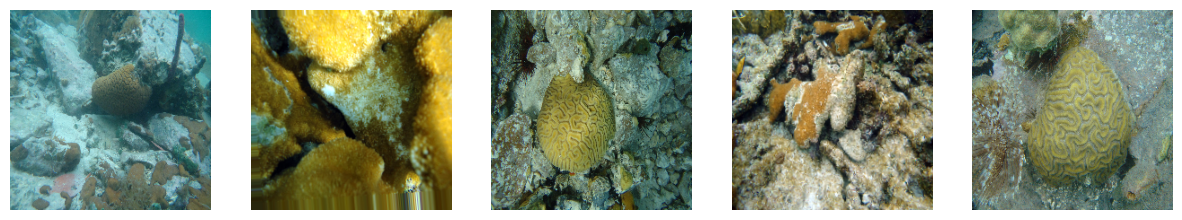

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of samples to display
num_samples_to_display = 5

# Create subplots to display the images
plt.figure(figsize=(15, 5))

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    
    # Normalize pixel values to the range [0, 1]
    # Swap color channels to convert from BGR to RGB
    plt.imshow(np.flip(X_train[i], axis=-1) / 255.0)
    
    plt.axis("off")

plt.show()


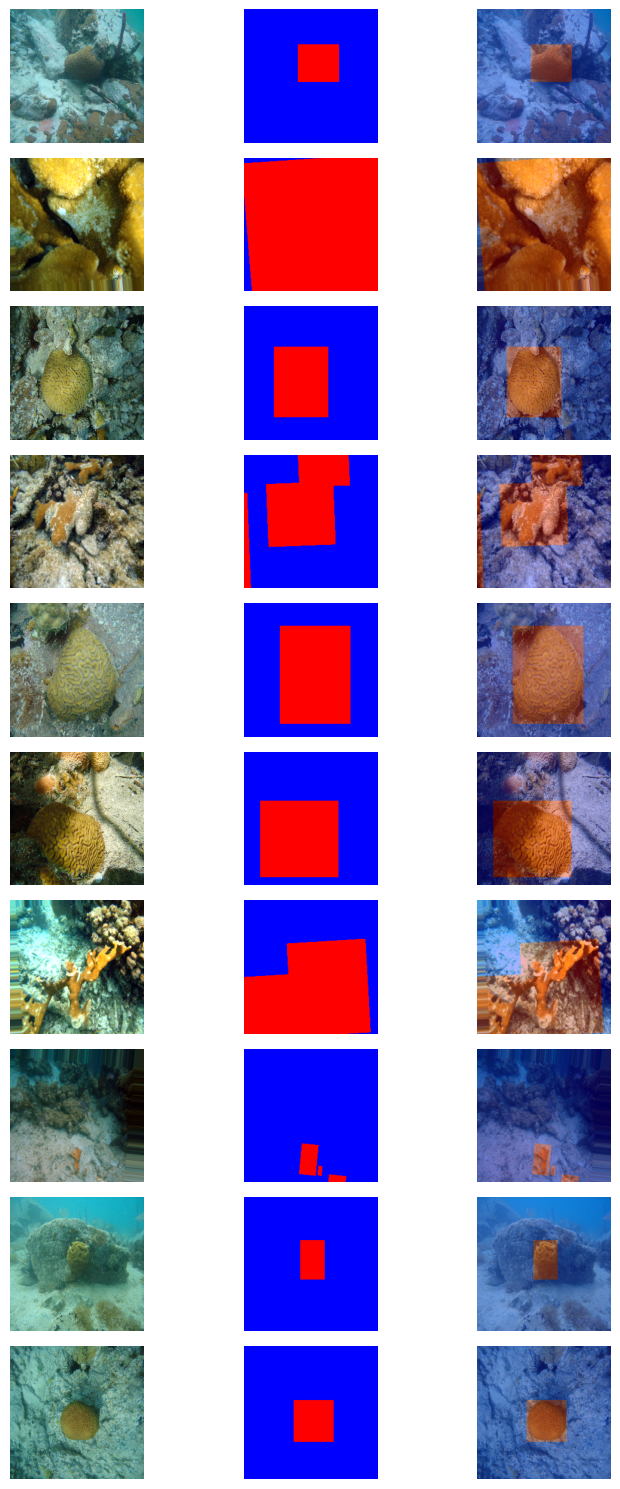

In [29]:
# Number of image-mask pairs to display
num_pairs_to_display = 10

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = np.flip(X_train[i], axis=-1)
    mask = y_train[i]

    # Create a blue mask for the back part
    blue_mask = np.zeros_like(mask)
    blue_mask[mask == 0] = 1

    # Create a red mask for the white part
    red_mask = np.zeros_like(mask)
    red_mask[mask != 0] = 1

    # Create a new image with blue and red regions based on the masks
    combined_mask = np.zeros_like(image)
    combined_mask[:, :, 0] = red_mask * 255  # Set the red channel to red_mask
    combined_mask[:, :, 2] = blue_mask * 255  # Set the blue channel to blue_mask

    # Ensure the values are in the valid range
    combined_mask = np.clip(combined_mask, 0, 255)

    # Overlay the combined mask on top of the original image
    overlay_image = image * 0.7 + combined_mask * 0.3

    # Ensure the values are in the valid range
    overlay_image = np.clip(overlay_image, 0, 255)

    # Plot the original image without conversion to grayscale
    plt.subplot(num_pairs_to_display, 3, 3 * i + 1)
    plt.imshow(np.flip(X_train[i], axis=-1) / 255.0)
    plt.axis('off')

    # Plot the modified mask with blue and red parts
    plt.subplot(num_pairs_to_display, 3, 3 * i + 2)
    plt.imshow(combined_mask.astype(np.uint8))
    plt.axis('off')

    # Plot the overlay image
    plt.subplot(num_pairs_to_display, 3, 3 * i + 3)
    plt.imshow(overlay_image.astype(np.uint8))
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [30]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0


In [31]:
print("Training Data - Min:", np.min(X_train), "Max:", np.max(X_train))
print("Validation Data - Min:", np.min(X_valid), "Max:", np.max(X_valid))
print("Test Data - Min:", np.min(X_test), "Max:", np.max(X_test))

Training Data - Min: 0.0 Max: 1.0
Validation Data - Min: 0.0 Max: 1.0
Test Data - Min: 0.0 Max: 1.0


In [32]:
y_test.shape

(2344, 224, 224)

In [33]:
print("Mask for Example 0:", y_test[8])

Mask for Example 0: [[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


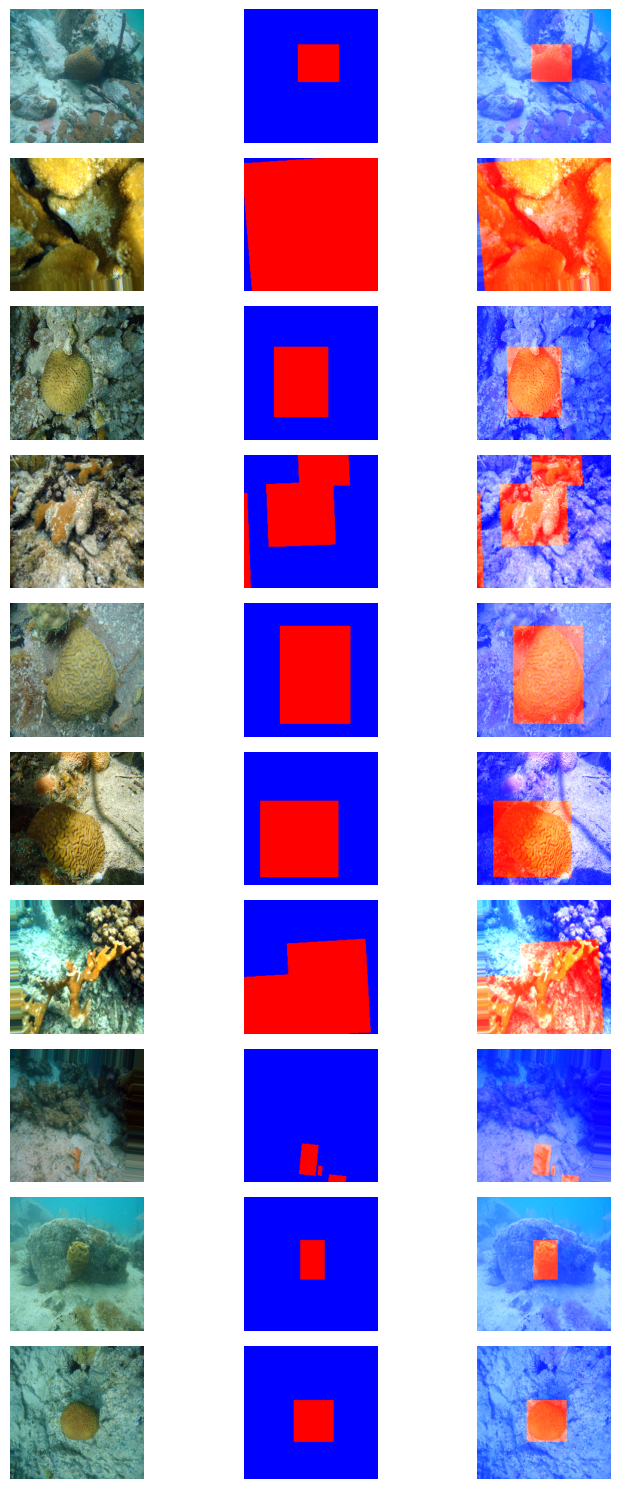

In [35]:
# Number of image-mask pairs to display
num_pairs_to_display = 10

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = np.flip(X_train[i], axis=-1)
    mask = y_train[i]

    # Create a blue mask for the back part
    blue_mask = np.zeros_like(mask)
    blue_mask[mask == 0] = 1

    # Create a red mask for the white part
    red_mask = np.zeros_like(mask)
    red_mask[mask != 0] = 1

    # Create a new image with blue and red regions based on the masks
    combined_mask = np.zeros_like(image)
    combined_mask[:, :, 0] = red_mask * 255  # Set the red channel to red_mask
    combined_mask[:, :, 2] = blue_mask * 255  # Set the blue channel to blue_mask

    # Ensure the values are in the valid range
    combined_mask = np.clip(combined_mask, 0, 255)

    # Overlay the combined mask on top of the original image
    overlay_image = image * (1 - combined_mask/255.0) + combined_mask

 
    # Ensure the values are in the valid range
    overlay_image = np.clip(overlay_image, 0, 1)

    # Plot the original normalized image
    plt.subplot(num_pairs_to_display, 3, 3 * i + 1)
    plt.imshow(image)
    plt.axis('off')

    # Plot the modified mask with blue and red parts
    plt.subplot(num_pairs_to_display, 3, 3 * i + 2)
    plt.imshow(combined_mask.astype(np.uint8))
    plt.axis('off')

    # Plot the overlay image
    plt.subplot(num_pairs_to_display, 3, 3 * i + 3)
    plt.imshow(overlay_image)
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def simplified_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bottleneck
    bottleneck = Conv2D(128, 3, activation='relu', padding='same')(pool1)

    # Expansive Path
    up1 = Concatenate()([UpSampling2D(size=(2, 2))(bottleneck), conv1])
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(up1)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv2)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the simplified U-Net model
model = simplified_unet()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [60]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
234/234 [==============================] - 1997s 9s/step - loss: 0.4904 - accuracy: 0.7838 - val_loss: 0.4750 - val_accuracy: 0.7913
Epoch 2/10
234/234 [==============================] - 1989s 8s/step - loss: 0.4669 - accuracy: 0.7946 - val_loss: 0.4623 - val_accuracy: 0.7970
Epoch 3/10
234/234 [==============================] - 1983s 8s/step - loss: 0.4607 - accuracy: 0.7986 - val_loss: 0.4595 - val_accuracy: 0.7991
Epoch 4/10
234/234 [==============================] - 1982s 8s/step - loss: 0.4542 - accuracy: 0.8024 - val_loss: 0.4523 - val_accuracy: 0.8048
Epoch 5/10
234/234 [==============================] - 1962s 8s/step - loss: 0.4515 - accuracy: 0.8039 - val_loss: 0.4511 - val_accuracy: 0.8041
Epoch 6/10
234/234 [==============================] - 1956s 8s/step - loss: 0.4487 - accuracy: 0.8053 - val_loss: 0.4475 - val_accuracy: 0.8070
Epoch 7/10
234/234 [==============================] - 1967s 8s/step - loss: 0.4467 - accuracy: 0.8065 - val_loss: 0.4468 - val_accuracy:

In [61]:
model.save('../models/coral_unet.h5')
# model.save('/content/drive/My Drive/Capstone/Pickled/coral_U-net.h5')

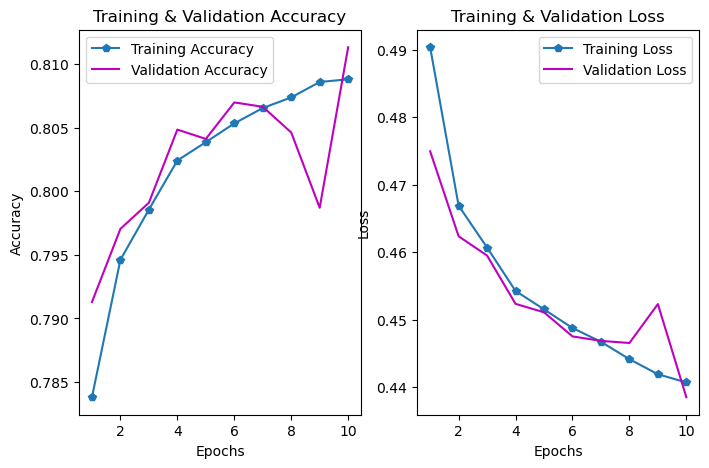

In [62]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [36]:
model = load_model('../models/coral_unet.h5')

In [37]:
# Assuming you have a function for evaluating the model on your test data, you can use it here.
# For example:
evaluation_results = model.evaluate(X_test, y_test)

# Assuming y_pred contains predicted masks for X_test
predicted_masks = model.predict(X_test)

# You can print or use the evaluation results as needed.
print("Evaluation Results:", evaluation_results)


74/74 [==============================] - 163s 2s/step
Evaluation Results: [0.42954927682876587, 0.8189875483512878]


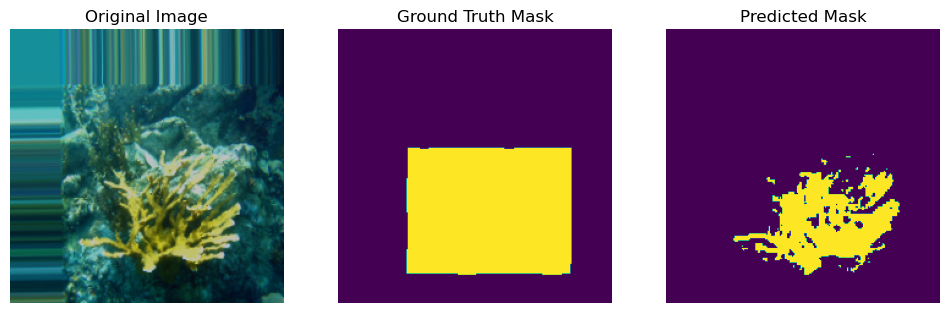

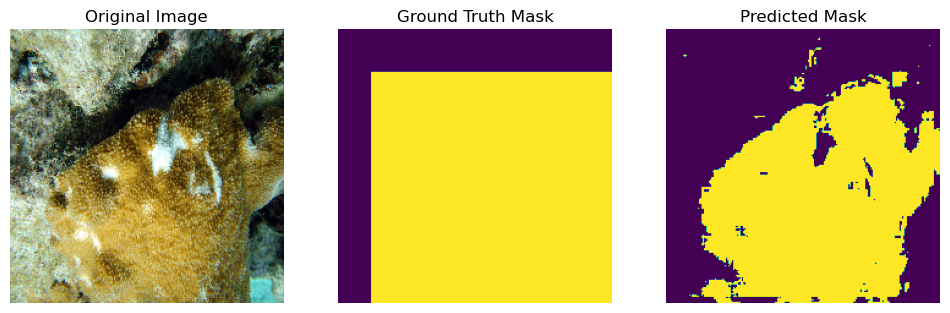

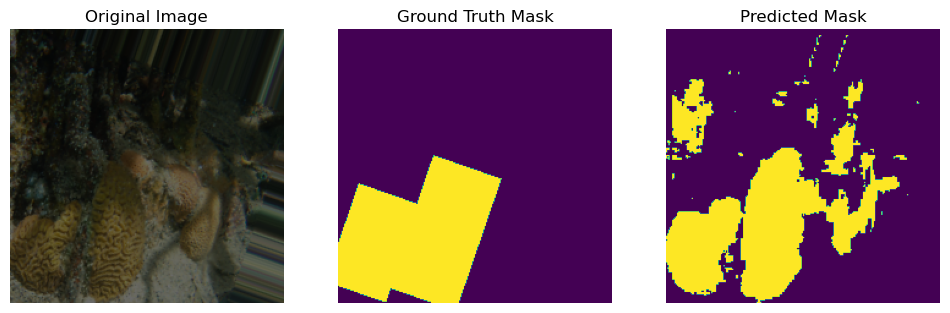

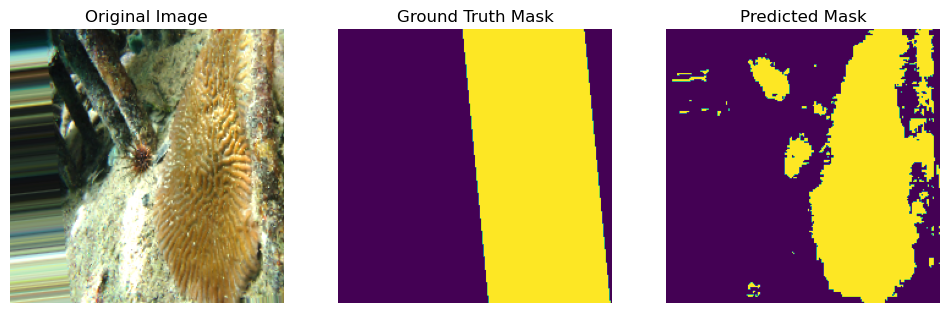

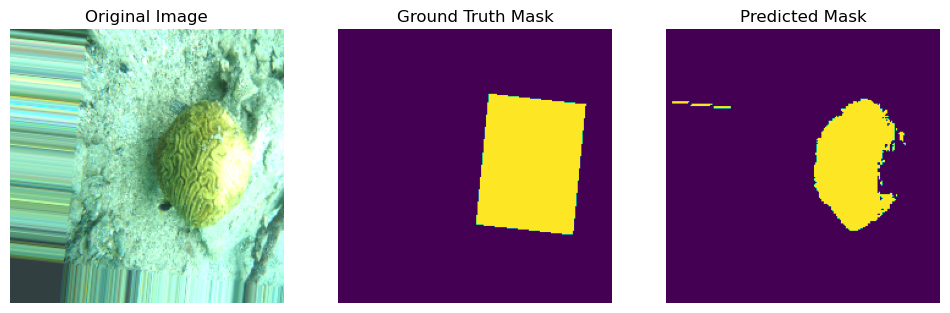

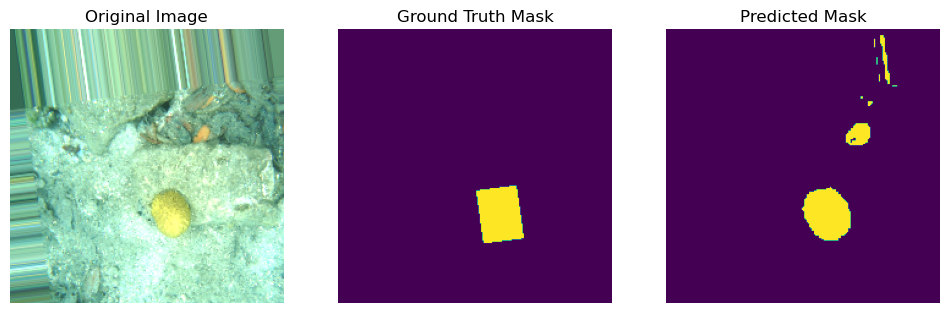

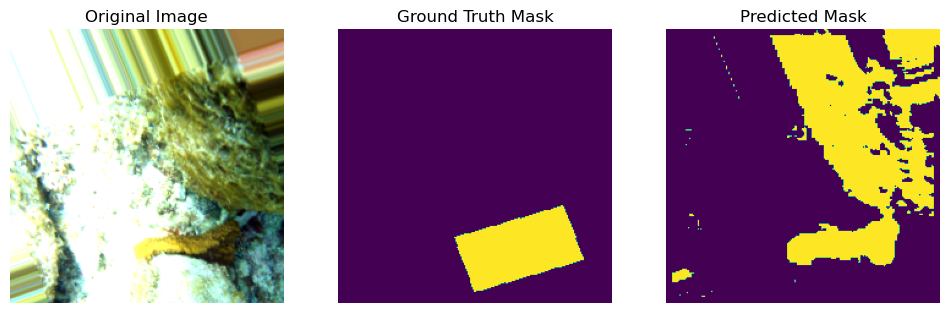

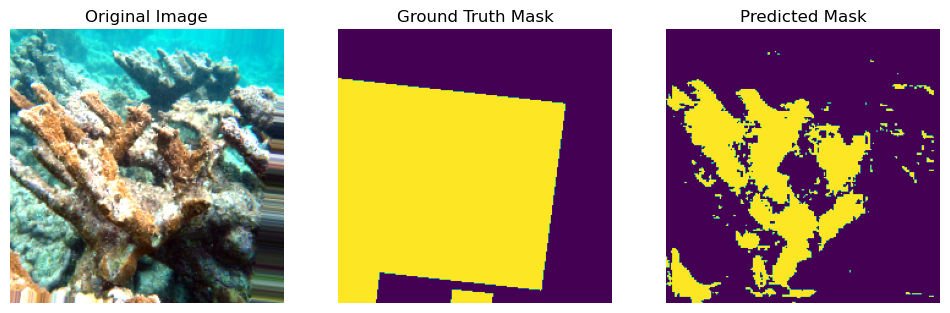

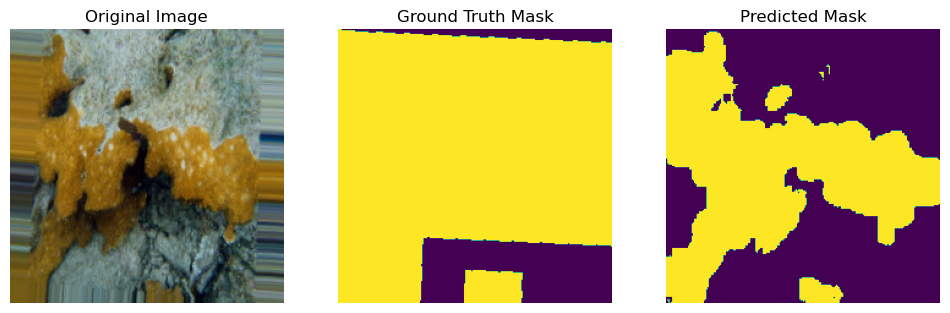

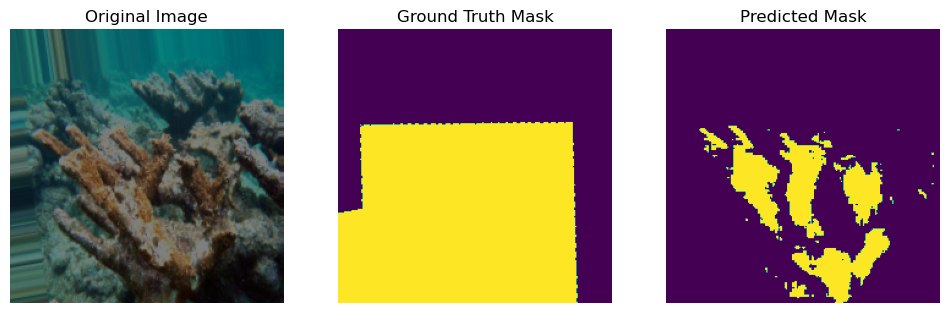

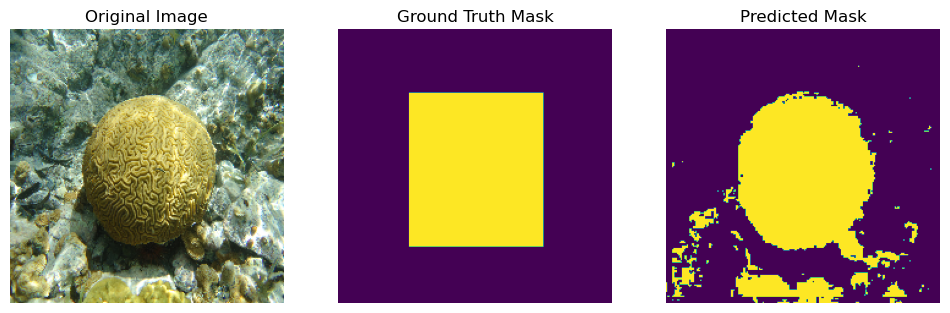

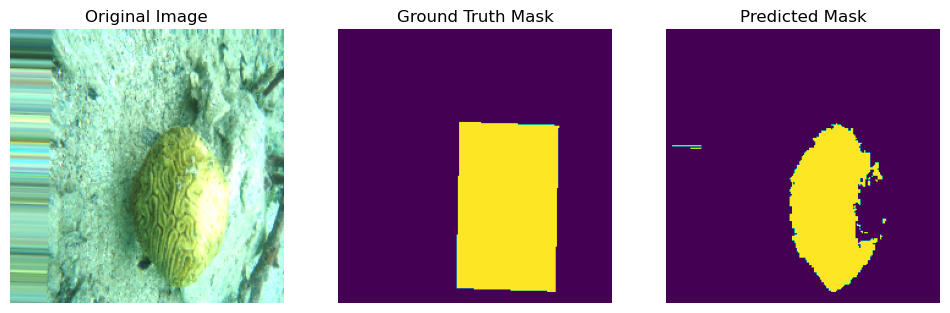

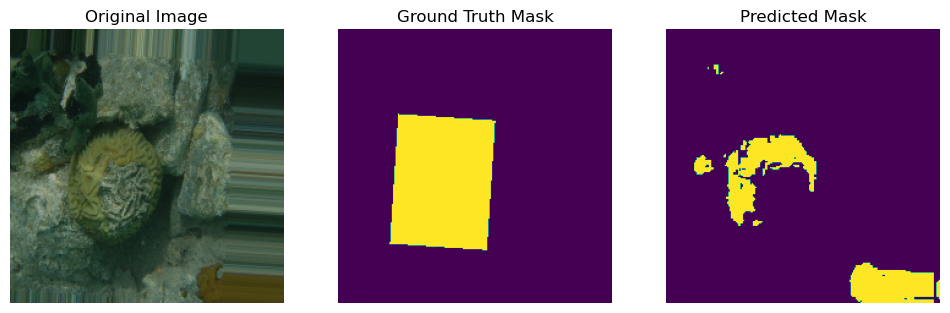

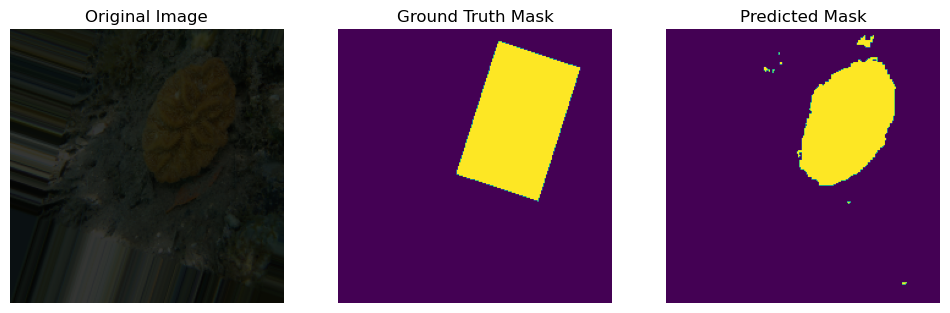

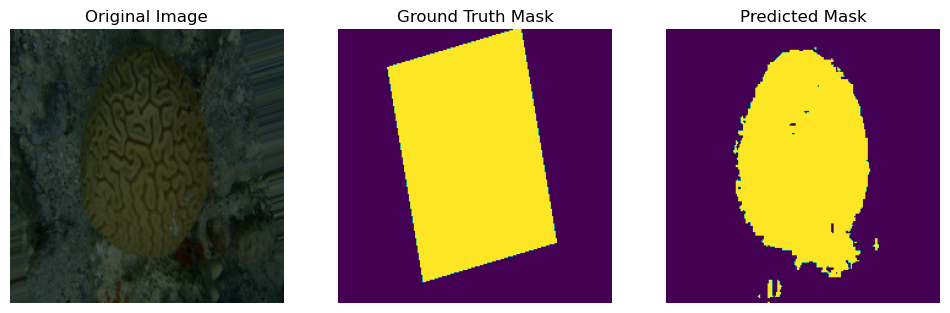

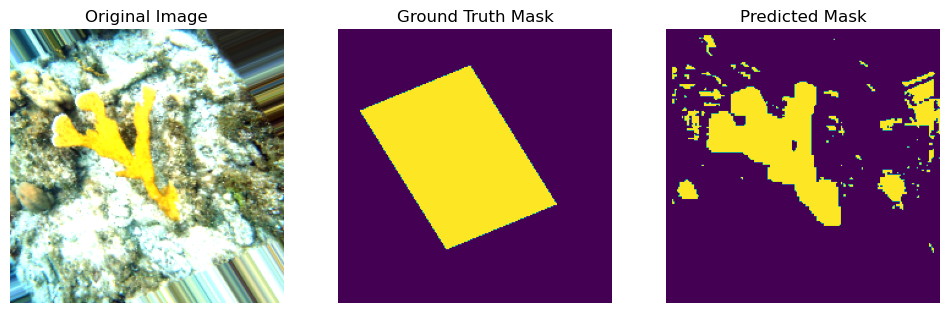

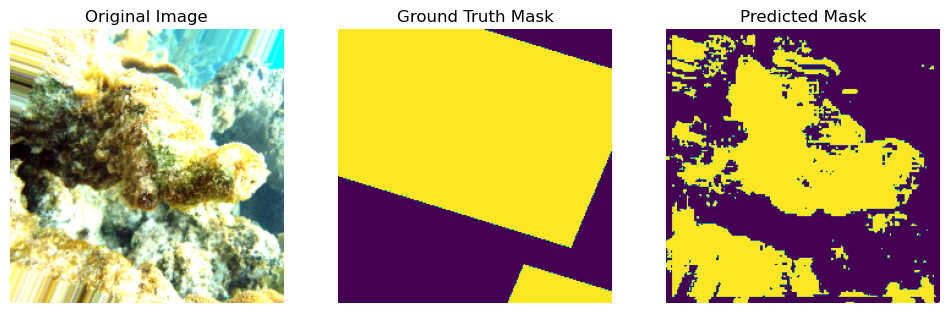

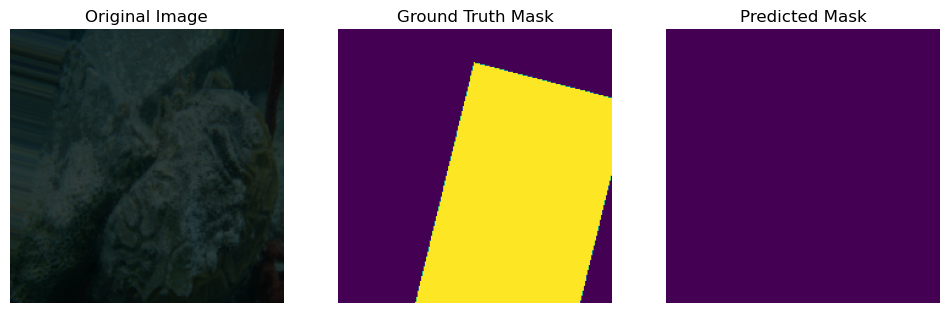

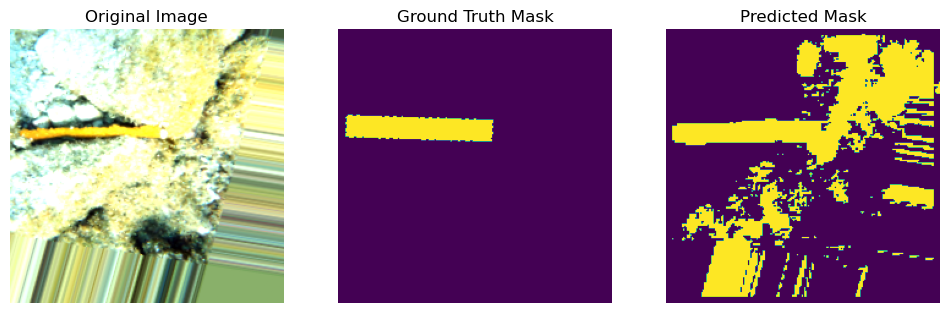

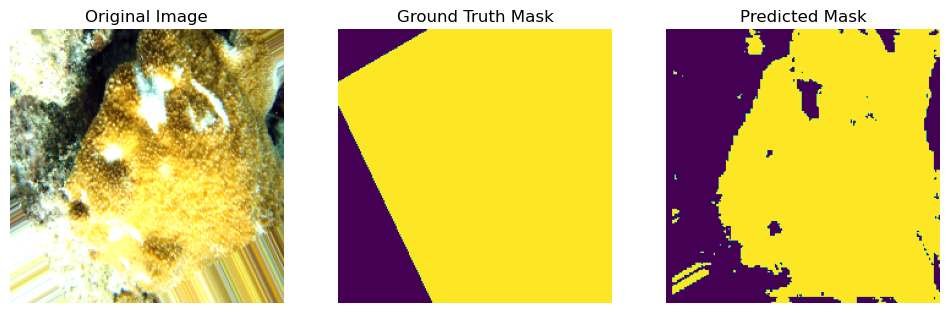

In [43]:
# Choose a few random images to visualize
num_images_to_visualize = 20
indices_to_visualize = np.random.choice(len(X_test), num_images_to_visualize, replace=False)

# Threshold for visualization
threshold = 0.5  # You may need to adjust this threshold based on your model and task

# Visualize the original image, ground truth mask, and predicted mask
for i in indices_to_visualize:
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(np.flip(X_test[i], axis=-1))
    plt.title('Original Image')
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    ground_truth_mask = y_test[i]
    plt.imshow(ground_truth_mask)
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    predicted_mask = (predicted_masks[i, :, :, 0] > threshold).astype(np.uint8)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

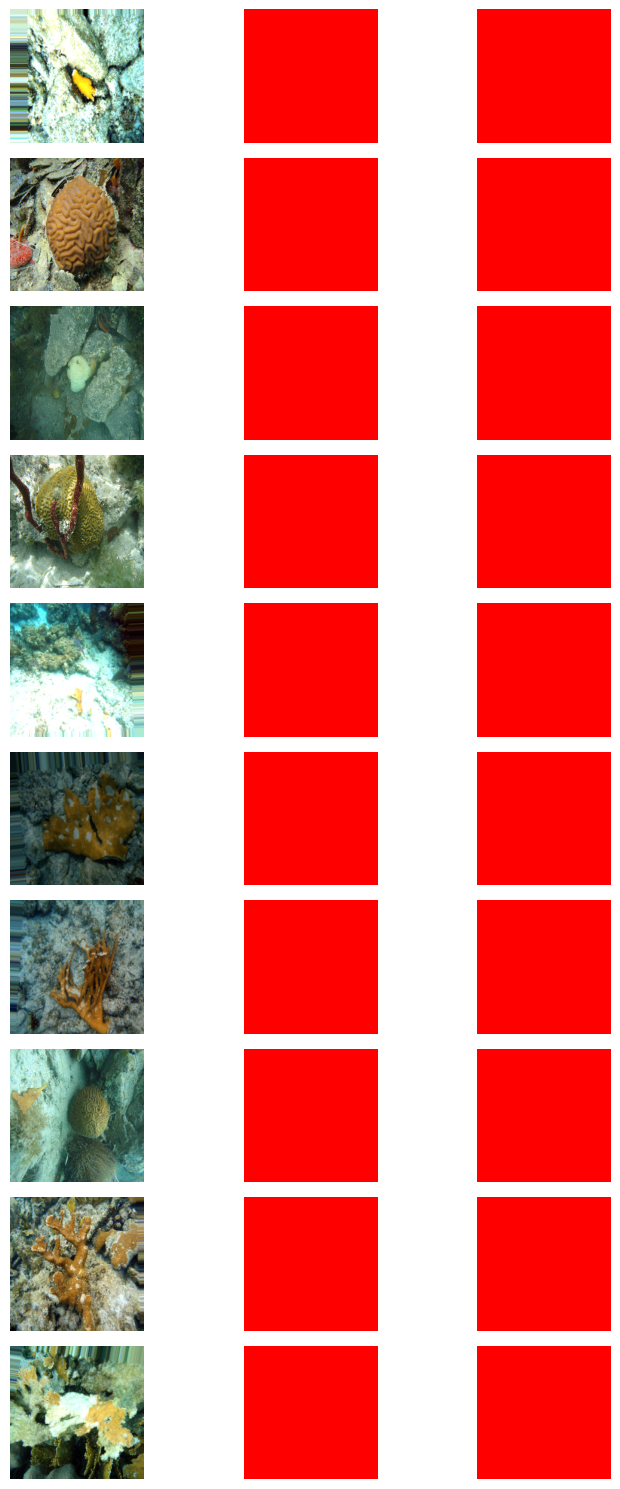

In [59]:
# Number of image-mask pairs to display
num_pairs_to_display = 10

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = np.flip(X_test[i], axis=-1)
    mask = predicted_masks[i]

    # Create a blue mask for the back part
    blue_mask = np.zeros_like(mask)
    blue_mask[mask == 0] = 1

    # Create a red mask for the white part
    red_mask = np.zeros_like(mask)
    red_mask[mask != 0] = 1

    # Ensure the masks are in the valid range
    blue_mask = np.clip(blue_mask, 0, 1)
    red_mask = np.clip(red_mask, 0, 1)

    # Overlay the combined mask on top of the original image
    overlay_image = np.zeros_like(image)
    overlay_image[:, :, 0] = (1 - red_mask[:, :, 0]) * image[:, :, 0] + red_mask[:, :, 0] * 255  # Set the red channel to red_mask
    overlay_image[:, :, 2] = (1 - blue_mask[:, :, 0]) * image[:, :, 2] + blue_mask[:, :, 0] * 255  # Set the blue channel to blue_mask

    # Ensure the values are in the valid range
    overlay_image = np.clip(overlay_image, 0, 255)

    # Plot the original normalized image
    plt.subplot(num_pairs_to_display, 3, 3 * i + 1)
    plt.imshow(image)
    plt.axis('off')

    # Plot the modified mask with blue and red parts
    plt.subplot(num_pairs_to_display, 3, 3 * i + 2)
    plt.imshow(np.clip(overlay_image.astype(np.uint8), 0, 255))  # Clip the overlay_image for display
    plt.axis('off')

    # Plot the overlay image
    plt.subplot(num_pairs_to_display, 3, 3 * i + 3)
    plt.imshow(overlay_image.astype(np.uint8))  # Ensure overlay_image is in uint8 format
    plt.axis('off')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [44]:
# print("Predicted Mask for Example 0:", predicted_masks[1])


In [65]:
print("Shape of Predicted Mask:", predicted_masks[0].shape)


Shape of Predicted Mask: (224, 224, 1)


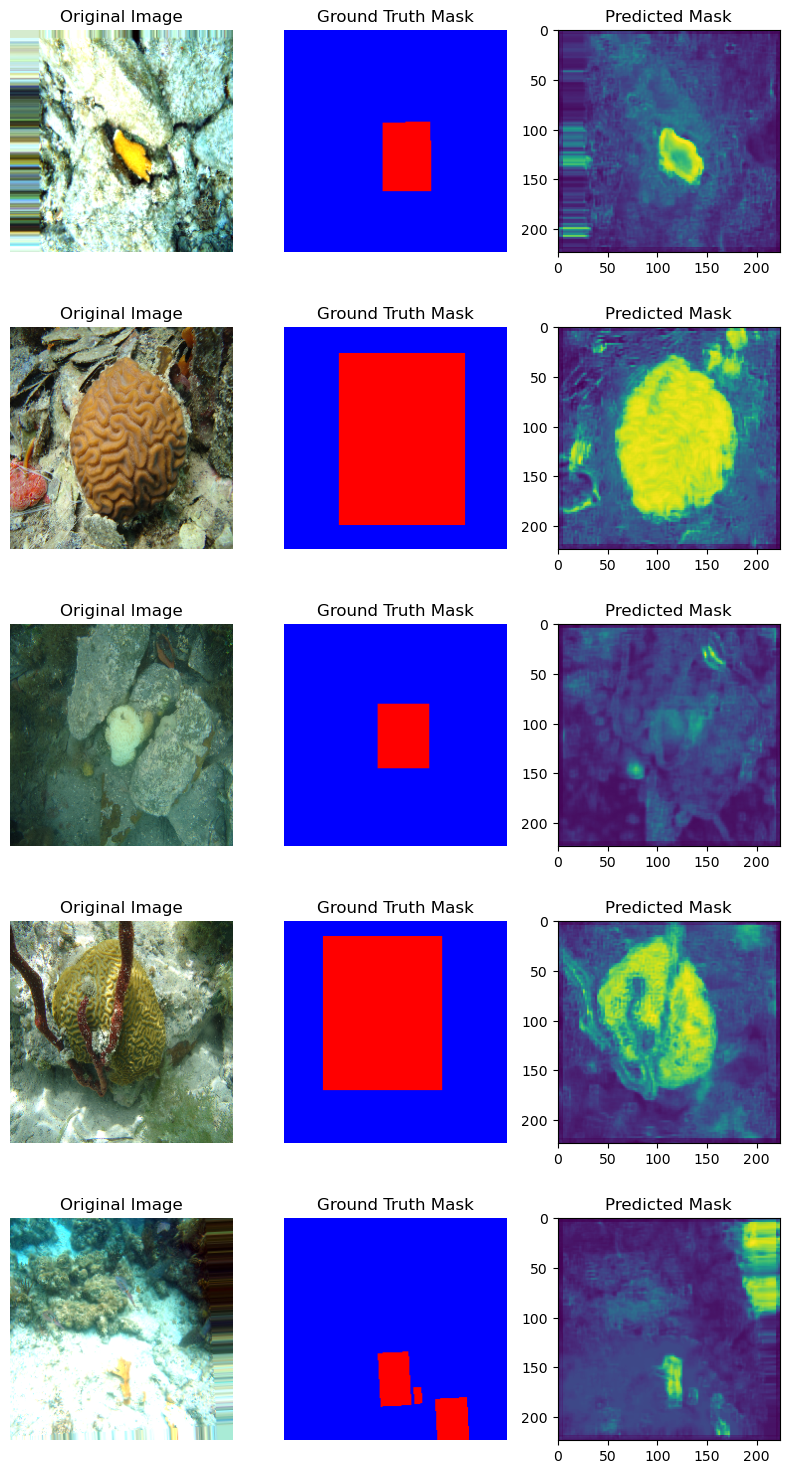

In [49]:
# Number of pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = np.flip(X_test[i], axis=-1)
    true_mask = y_test[i]
    predicted_mask = predicted_masks[i]

    # Create a blue mask for the back part
    blue_mask = np.zeros_like(true_mask)
    blue_mask[true_mask == 0] = 1

    # Create a red mask for the white part
    red_mask = np.zeros_like(true_mask)
    red_mask[true_mask != 0] = 1

    # Create a new image with blue and red regions based on the masks
    combined_mask = np.zeros_like(image)
    combined_mask[:, :, 0] = red_mask * 255  # Set the red channel to red_mask
    combined_mask[:, :, 2] = blue_mask * 255  # Set the blue channel to blue_mask

    # Ensure the values are in the valid range
    combined_mask = np.clip(combined_mask, 0, 255)

    # Overlay the combined mask on top of the original image
    overlay_image = image * 0.7 + combined_mask * 0.3

    # Ensure the values are in the valid range
    overlay_image = np.clip(overlay_image, 0, 255)

    # Plot the original image without conversion to grayscale
    axes[i, 0].imshow(np.flip(X_test[i], axis=-1))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    # Plot the ground truth mask with blue and red parts
    axes[i, 1].imshow(combined_mask.astype(np.uint8))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth Mask')

    # Plot the predicted mask
    axes[i, 2].imshow(predicted_mask)
    axes[i, 2].set_title('Predicted Mask')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
